In [75]:
import baseline
import importlib
importlib.reload(baseline)
from baseline import *
import numpy as np 
import pandas as pd

In [76]:
#Data loading and reduce memory usage by changing dtypes
files = ['train.csv', 'test.csv', 'shops.csv', 'items.csv', 'item_categories.csv']

data = [loader(file_name) for file_name in files]

In [77]:
full_data, train = prepare_full_data(*data)
reduce_mem_usage(full_data, verbose=False)

c:\Users\User\OneDrive\Рабочий стол\Trainee\baseline.py:77: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  full_data = pd.concat([full_data, test], keys=columns, ignore_index=True, sort=False)
c:\Users\User\OneDrive\Рабочий стол\Trainee\venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_cnt_month,item_id,city_id,item_category_id,main_category_id,minor_category_id
0,0,0,0.0,19,0,40,6,6
1,0,0,1.0,27,0,19,4,12
2,0,0,0.0,28,0,30,4,57
3,0,0,0.0,29,0,23,4,18
4,0,0,0.0,32,0,40,6,6
...,...,...,...,...,...,...,...,...
11054177,34,41,0.0,18454,20,55,8,4
11054178,34,41,0.0,16188,20,64,9,44
11054179,34,41,0.0,15757,20,55,8,4
11054180,34,41,0.0,19648,20,40,6,6


In [78]:
#Check if our train data is valid
column_types = {'date_block_num': 'int8', 'shop_id': 'int8', 'city_id': 'int8', 'item_id': 'int16', 'item_cnt_month': 'float16',
'item_category_id': 'int8', 'main_category_id': 'int8', 'minor_category_id': 'int8'}
values_ranges = {'date_block_num': (0, 34), 'shop_id': (0, 59), 'item_id': (0, 22169), 'item_cnt_month': (0, 669), 'city_id':(0,30),
                'item_category_id': (0,83), 'main_category_id': (0,11), 'minor_category_id': (0, 66)}
Validator(column_types = column_types, value_ranges = values_ranges, check_missing = True, check_duplicates=True).fit_transform(full_data)

'Data is valid'

Feature exctraction

In [79]:
feature_extractor = FeatureExtractor(full_data, train)
full_featured_data = feature_extractor.process()
reduce_mem_usage(full_featured_data, verbose=False)

c:\Users\User\OneDrive\Рабочий стол\Trainee\baseline.py:527: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.full_data['months_from_last_sale'].fillna(-1, inplace=True)
c:\Users\User\OneDrive\Рабочий стол\Trainee\venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\User\OneDrive\Рабочий стол\Trainee\venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (ab

,date_block_num,shop_id,item_cnt_month,item_id,city_id,item_category_id,main_category_id,minor_category_id,shop_history,item_history,...,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,sales_per_category_per_shop_lag_1,sales_per_item_lag_1,delta_revenue_lag_1,delta_price_lag_1,months_from_last_sale,months_from_first_sale
0,0,0,0.0,19,0,40,6,6,34,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
1,0,0,1.0,27,0,19,4,12,34,16.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
2,0,0,0.0,28,0,30,4,57,34,13.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
3,0,0,0.0,29,0,23,4,18,34,7.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
4,0,0,0.0,32,0,40,6,6,34,34.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054177,34,41,0.0,18454,20,55,8,4,34,11.0,...,0.0,0.0,0.0,0.0,19409.0,198.000000,653.0,-0.457275,1.0,11
11054178,34,41,0.0,16188,20,64,9,44,34,2.0,...,0.0,0.0,0.0,0.0,15111.0,1359.000000,653.0,0.081116,1.0,2
11054179,34,41,0.0,15757,20,55,8,4,34,34.0,...,0.0,0.0,0.0,0.0,19409.0,1145.000000,653.0,0.154419,1.0,34
11054180,34,41,0.0,19648,20,40,6,6,34,11.0,...,0.0,0.0,0.0,0.0,23543.0,178.199997,653.0,-0.089966,1.0,11


In [70]:
full_featured_data.to_csv('full_data.csv', index = False)

Train/Test split

XGBRegressor
RMSE for split 1: 0.724
RMSE for split 2: 0.676
RMSE for split 3: 0.690
Mean RMSE for all splits: 0.696


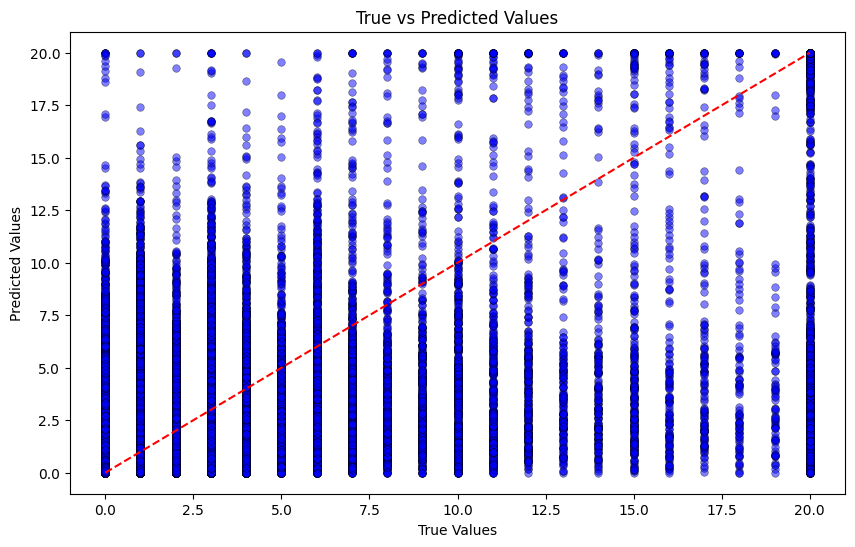

In [80]:
#Validation
tss_cv(df = full_featured_data, n_splits=3, model = XGBRegressor(), true_pred_plot=True)    

In [ ]:
#Training
X_train, y_train, X_val, y_val, X_test = data_split(full_featured_data)